In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pyflux as pf
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as sm
import scipy.stats as sp
from sklearn.metrics import mean_squared_error as rmse

# Importing Microsoft stock data obtained from Quandl website and have a quick peek to see what the dataset contains 

In [2]:
msft = pd.DataFrame.from_csv('MSFT.csv')
msft = msft.interpolate()
msft.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-09-15,56.15,57.350,55.98,57.19,26435104.0,0.0,1.0,56.15,57.350,55.98,57.19,26435104.0
2016-09-14,56.39,56.630,56.03,56.26,23616182.0,0.0,1.0,56.39,56.630,56.03,56.26,23616182.0
2016-09-13,56.50,56.650,56.05,56.53,29465088.0,0.0,1.0,56.50,56.650,56.05,56.53,29465088.0
2016-09-12,56.00,57.205,55.61,57.05,28441578.0,0.0,1.0,56.00,57.205,55.61,57.05,28441578.0
2016-09-09,56.79,57.520,56.21,56.21,33475922.0,0.0,1.0,56.79,57.520,56.21,56.21,33475922.0


# Q1 Can you count something interesting?

In [3]:
msft.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,7682.000000,7682.000000,7682.000000,7682.000000,7.682000e+03,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7.682000e+03
mean,59.214550,60.066258,58.395240,59.259573,3.152511e+07,0.001530,1.001041,16.624289,16.816607,16.437196,16.629622,6.412129e+07
std,33.128003,33.654626,32.599529,33.166756,3.266399e+07,0.038512,0.031231,13.699375,13.836959,13.567719,13.708190,3.906258e+07
min,15.200000,15.620000,14.870000,15.150000,8.000000e+03,0.000000,1.000000,0.060989,0.063380,0.060989,0.062184,2.304000e+06
25%,28.620000,28.902500,28.312500,28.592500,2.097475e+06,0.000000,1.000000,1.872707,1.894232,1.840419,1.872707,4.160310e+07
50%,52.620000,53.492500,51.785000,52.685000,2.706805e+07,0.000000,1.000000,18.749426,18.959404,18.488035,18.751883,5.690565e+07
75%,84.000000,85.202500,82.750000,84.000000,5.111178e+07,0.000000,1.000000,23.988725,24.231238,23.711535,23.983344,7.683590e+07
max,178.940000,180.380000,175.750000,179.940000,5.910522e+08,3.080000,2.000000,58.280000,58.700000,58.100000,58.180500,1.031789e+09


In [4]:
178/15

11

On average, Closing value is higher then Opening value slightly. While the highest traded is 11 times highest than the lowest traded value. 

# As the data contains multiple data, I will focus on just the Open stock values

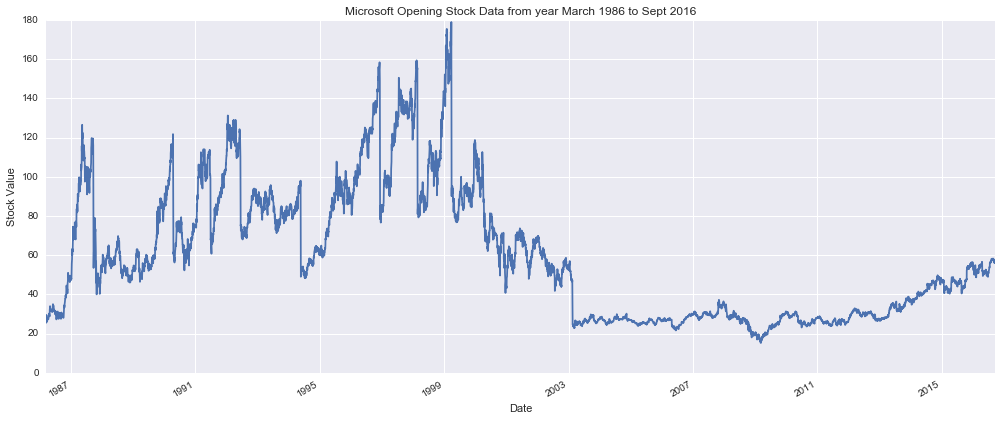

In [5]:
msftO = msft.Open

plt.figure(figsize=(17,7))
plt.title('Microsoft Opening Stock Data from year March 1986 to Sept 2016')
plt.xlabel('Time (Year)')
plt.ylabel('Stock Value')

msftplot = msftO.plot()

# Q2 Can you find some trends (high, low, increase, decrease, anomalies)?
Before the year 2003, stock value fluctuates immensely with rapid rise and stee;p drops happening at a glance from the plot. However after the year drop in 2003, (presumably linked to the recession) the stock prices seems to be more stable relative to previous years, until circa 2013 where the value increases slowly.

# Q3 Can you make a bar plot or a histogram?
Yes, but as this is a time series data, line plot is better


(array([ 2587.,   863.,  1372.,   758.,  1003.,   498.,   316.,   199.,
           65.,    21.]),
 array([  15.2  ,   31.574,   47.948,   64.322,   80.696,   97.07 ,
         113.444,  129.818,  146.192,  162.566,  178.94 ]),
 <a list of 10 Patch objects>)

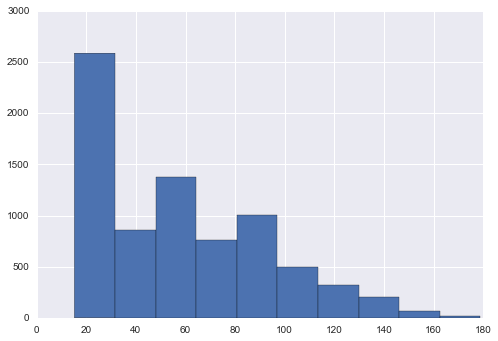

In [6]:
#histogram that makes no sense
plt.hist(msftO)

# Choosing Data for Time Series Model for Prediction
As this is a massive dataset, I will only using a dataset from one year for quick model building with the idea of making predictions of future stock value. Which will be hopefully be validated with data of the following year. Two separate models will be built, one from pre 2003 which fluctuates a lot more and one from post 2003 which is more stable relatively. Data from year 1991 and 2005 will be used.

In [40]:
yr1991 = pd.date_range('1991-01-01', '1991-12-31', freq='D')
yr2005 = pd.date_range('2005-01-01', '2005-12-31', freq='D')

msft1991 = msft.loc[yr1991].interpolate().fillna(msft.mean())
msft2005 = msft.loc[yr2005].interpolate().fillna(msft.mean())
open1991 = msft1991.Open
open2005 = msft2005.Open

I will be constructing ARIMA model which requires determining the AR and MA order
# First model for 1991

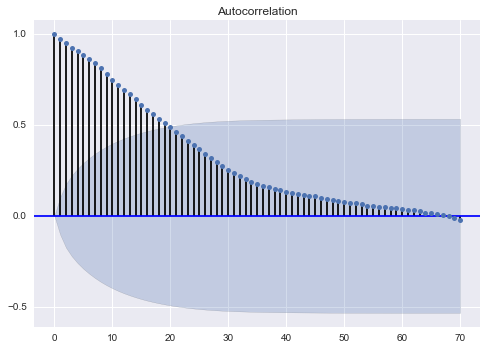

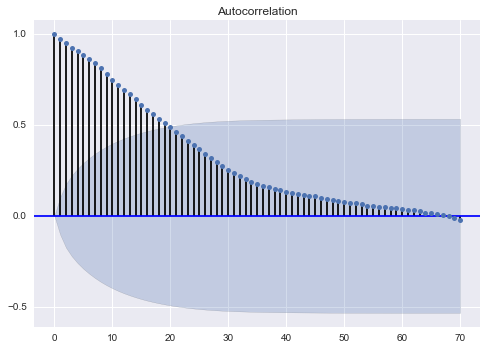

In [41]:
##determining the MA order
smt.graphics.plot_acf(open1991, lags = 70)

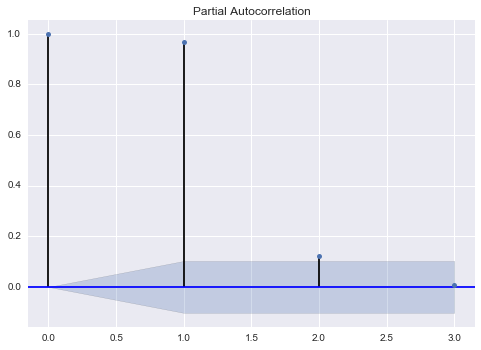

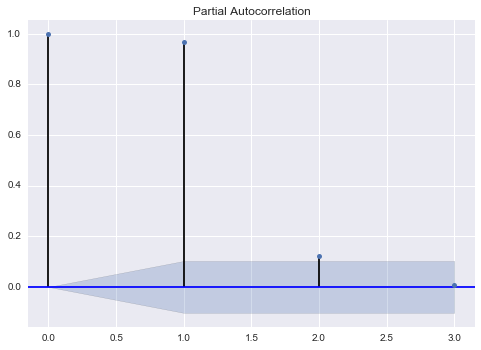

In [42]:
##now the AR order
smt.graphics.plot_pacf(open1991, lags = 3)

In [43]:
arima1991 = pf.ARIMA(msft1991, ar=2, ma=68, integ=1, target='Open')

In [44]:
fit1991 = arima1991.fit("MLE")
fit1991.summary()

ARIMA(2,1,68)                                                                                             
======================================================= ==================================================
Dependent Variable: Differenced Open                    Method: MLE                                       
Start Date: 1991-03-10 00:00:00                         Log Likelihood: -637.3043                         
End Date: 1991-12-31 00:00:00                           AIC: 1418.6087                                    
Number of observations: 296                             BIC: 1684.3145                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0106     0.0942     0.112    0.9108   (-0.1741 | 0.1952)       
AR(1)                                

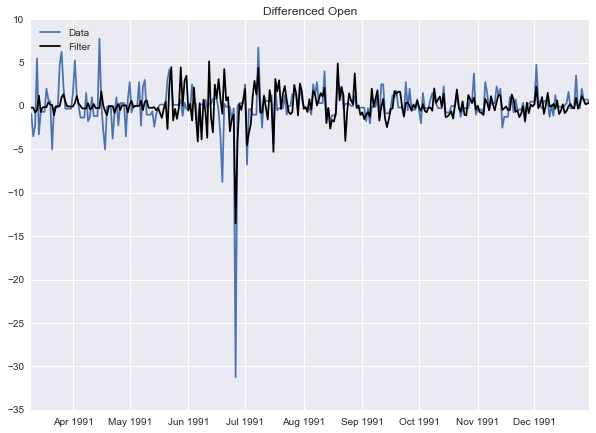

In [45]:
arima1991.plot_fit()

# Completed 1991 arima model 
now let's make some prediction and compare with the original data

In [46]:
##predicting 75 days ahead
pred1992 = arima1991.predict(h=75).Open
##getting original data to compare
yr1992 = pd.date_range(pred1991.index.min(), pred1991.index.max(), freq='D')
msft1992 = msft.loc[yr1992].interpolate().fillna(method='bfill')
ori1992 = msft1992.Open

pred1992 = pred1992.reindex(pd.date_range(start=pred1992.index.min(), end=pred1992.index.max(),freq='1D')) 
ori1992 = ori1992.reindex(pd.date_range(start=ori1992.index.min(), end=ori1992.index.max(),freq='1D')) 

pred1992 = pred1992.interpolate(method='time')
ori1992 = ori1992.interpolate(method='time')

pred1992.plot(color='red')
ori1992.plot(color='blue')

AttributeError: 'DataFrame' object has no attribute 'Open'

# Evaluating accuracy of the prediction 
After making prediction with the model and plotting the results, lets evaluate the prediction with correlation methods

In [129]:
#pearson correlation

pred1992list = np.array(pred1992.tolist())
ori1992list = np.array(ori1992.tolist())

sp.pearsonr(ori1992list, pred1992list)

(-0.39469673918767401, 2.5885307355991366e-05)

The pearson correlation coefficient indicates the prediction have slight negative correlation 

In [130]:
error = [((x-y)/y)**2 for x, y in zip(pred1992list, ori1992list)]
np.sqrt(np.sum(error))

1.2911779314154694

The normalised Root-Mean-Squared-Error does not indicate the prediction is good model too.

# Lets try with 2005 data

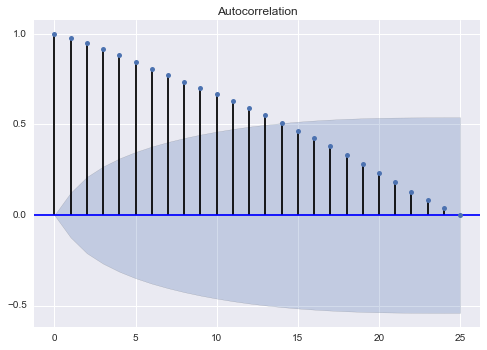

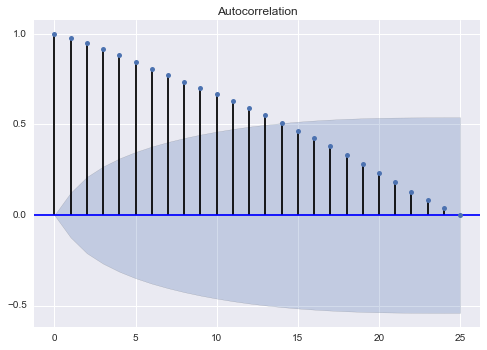

In [131]:
smt.graphics.plot_acf(open2005, lags = 25)

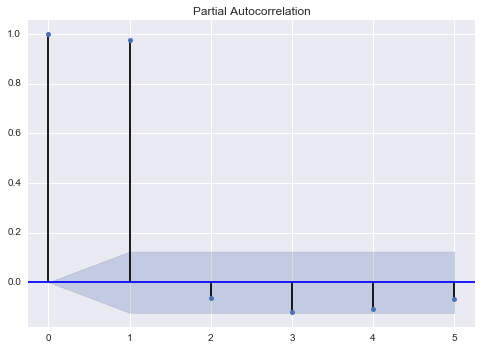

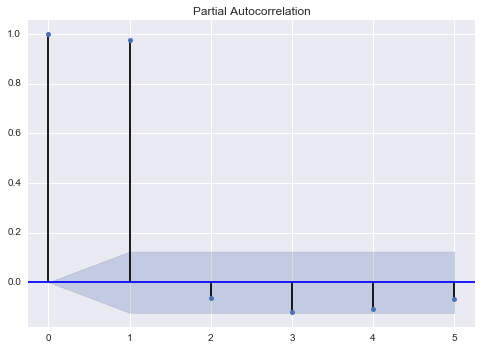

In [132]:
smt.graphics.plot_pacf(open2005, lags = 5)

In [138]:
arima2005 = pf.ARIMA(msft2005, ar=2, ma=25, integ=0, target='Open')

In [139]:
arima2005.fit()

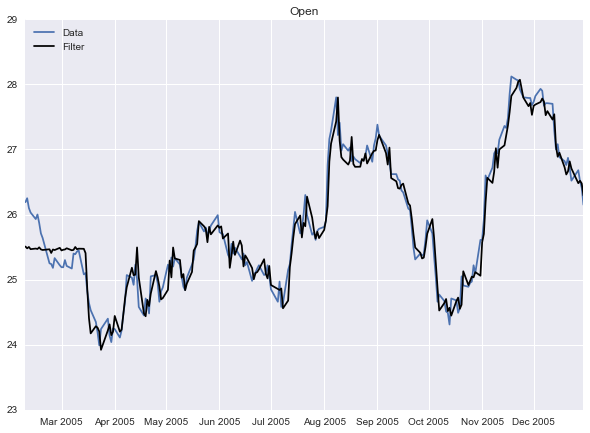

In [140]:
arima2005.plot_fit()

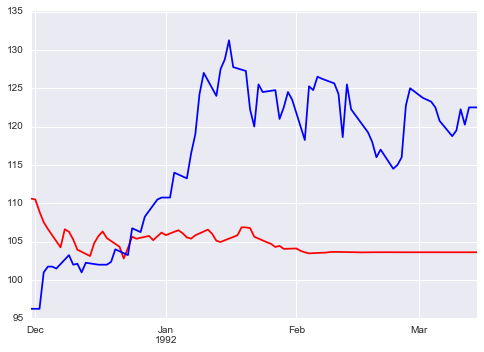

In [145]:
pred2006 = arima2005.predict(h=75).Open

yr2006 = pd.date_range(pred1991.index.min(), pred1991.index.max(), freq='D')
msft2006 = msft.loc[yr2006].interpolate()
ori2006 = msft2006.Open

pred2006 = pred2006.reindex(pd.date_range(start=pred2006.index.min(), end=pred2006.index.max(),freq='1D')) 
ori2006 = ori2006.reindex(pd.date_range(start=ori2006.index.min(), end=ori2006.index.max(),freq='1D')) 

pred2006 = pred1992.interpolate(method='time')
ori2006 = ori1992.interpolate(method='time')

pred2006.plot(color='red')
ori2006.plot(color='blue')

In [149]:
pred2006list = np.array(pred2006.tolist())
ori2006list = np.array(ori2006.tolist())

print('Pearson Correlation Coeefiecient: ', sp.pearsonr(ori2006list, pred2006list))

error2 = [((x-y)/y)**2 for x, y in zip(pred2006list, ori2006list)]
print ("RMSE",np.sqrt(np.sum(error2)))

('Pearson Correlation Coeefiecient: ', (-0.39469673918767401, 2.5885307355991366e-05))
('RMSE', 1.2911779314154694)
